In [1]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
from datetime import timedelta

In [2]:
mid_night = datetime.datetime.strptime('23:59:59', '%H:%M:%S').time()
noon = datetime.datetime.strptime('12:00:00', '%H:%M:%S').time()
def str_to_time(x, start_time):
    if start_time.time() > noon: 
        if noon < datetime.datetime.strptime(x[:-4], '%H:%M:%S').time() < mid_night:
            return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S')
        else:
            return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S') + timedelta(days=1)
    else:
        return datetime.datetime.strptime(str(start_time.date()) + " " + x[:-4], '%Y-%m-%d %H:%M:%S')

In [3]:
def round_time(x):
    timestamp = datetime.datetime.strptime(x[0:10] + " " + x[11:-6], '%Y-%m-%d %H:%M:%S.%f')
    if timestamp.time().microsecond >= 500000:
        return datetime.datetime.strptime(x[0:10] + " " + x[11:-10], '%Y-%m-%d %H:%M:%S') + timedelta(seconds=1)
    else:
        return datetime.datetime.strptime(x[0:10] + " " + x[11:-10], '%Y-%m-%d %H:%M:%S')
    
    

In [8]:
rootdir = '../Sleep Data/'
sleep_profiles = []
xethru_recordings = []

for subdir, dirs, files in os.walk(rootdir):
    subdir_split = subdir.split('/')
    subdir_und = subdir_split[-1].split('_')
    
    current_xethru_recording = pd.DataFrame(columns=["time", "frame_count", "state", "rpm", "object_distance", 
                                        "signal_quality", "movement_slow", "movement_fast"])
    
    isFirstFile = True
    
    CSVCount = 0
            
    for file in files:        
        if (file == 'Sleep profile.txt' ) & ('PSG_analysis_manual' in subdir_split):
            start_time = ''
            with open(os.path.join(subdir, file)) as f:
                head = [next(f) for x in range(2)]
                start_time = datetime.datetime.strptime(head[1][12:-1], '%d.%m.%Y %H:%M:%S')
                
            sleep_profile = pd.read_csv(os.path.join(subdir, file), sep=";", skiprows=7, header=None)
            sleep_profile.columns = ["time", "stage"]
            sleep_profile['time'] = sleep_profile['time'].apply(lambda x: str_to_time(x, start_time))
            sleep_profiles.append(sleep_profile)
        
        file_split = file.split('_')
        
        if 'xethru' in file_split and 'sleep' in file_split and 'nattbord' in subdir_und:
            numCSVs = len(glob.glob1(subdir, "*.csv"))
            
            CSVCount = CSVCount + 1
            
            xethru_recording = pd.read_csv(os.path.join(subdir, file), sep=";", skiprows=1, header=None)

            xethru_recording.columns = ["time", "frame_count", "state", "rpm", "object_distance", 
                                        "signal_quality", "movement_slow", "movement_fast"]
            
            xethru_recording['time'] = xethru_recording['time'].apply(lambda x: round_time(x))
            
            start_timestamp = sleep_profiles[-1]['time'].iloc[0]
            end_timestamp = sleep_profiles[-1]['time'].iloc[-1]
            
            print(subdir)
            print('start_timestamp', start_timestamp)
            print('xethru_timestamp', str(xethru_recording['time'].iloc[0]) + '\n')
            
            while isFirstFile and xethru_recording['time'].iloc[0] >= start_timestamp:                
                sleep_profiles[-1] = sleep_profiles[-1].iloc[1:]
                print('sleep_profile length', len(sleep_profiles[-1]))
                start_timestamp = sleep_profiles[-1]['time'].iloc[0]
                               
            while (numCSVs == CSVCount) and xethru_recording['time'].iloc[-1] <= end_timestamp:                
                sleep_profiles[-1] = sleep_profiles[-1].iloc[:1]                
                end_timestamp = sleep_profiles[-1]['time'].iloc[-1]
                                               
            current_xethru_recording = current_xethru_recording.append(xethru_recording)
                        
            isFirstFile = False            
    
    if len(current_xethru_recording) > 0 and 'nattbord' in subdir_und:
#         current_xethru_recording = current_xethru_recording.drop_duplicates('time', keep='first')
        for x in range(1, current_xethru_recording.shape[0]):
            if (current_xethru_recording['time'].iloc[x]) != (current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)):
                time_adjusted = current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)
                current_xethru_recording['time'].iloc[x] = time_adjusted

        for x in range(1, current_xethru_recording.shape[0]):
            if (current_xethru_recording['time'].iloc[x]) != (current_xethru_recording['time'].iloc[x-1] + timedelta(seconds=1)):
                print(subdir)
                print('t1', current_xethru_recording['time'].iloc[x-1])
                print('t2', str(current_xethru_recording['time'].iloc[x]) + '\n')

        start_timestamp = sleep_profiles[-1]['time'].iloc[0]
        end_timestamp = sleep_profiles[-1]['time'].iloc[-1] + timedelta(seconds=29)
        current_xethru_recording = current_xethru_recording[current_xethru_recording['time'].map(lambda x: start_timestamp <= x <= end_timestamp)]        
        xethru_recordings.append(current_xethru_recording)

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 2017-11-22 23:45:00
xethru_timestamp 2017-11-22 23:14:40

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 2017-11-22 23:45:00
xethru_timestamp 2017-11-23 00:14:40

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 2017-11-22 23:45:00
xethru_timestamp 2017-11-23 01:14:41

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 2017-11-22 23:45:00
xethru_timestamp 2017-11-23 02:14:42

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 2017-11-22 23:45:00
xethru_timestamp 2017-11-23 03:14:43

../Sleep Data/raw_data_1/101/xethru_recording_20171122_231439_x4m200_17FPS_P101_nattbord_100000010083
start_timestamp 20

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 2017-11-26 22:16:00
xethru_timestamp 2017-11-27 00:56:48

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 2017-11-26 22:16:00
xethru_timestamp 2017-11-27 01:56:49

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 2017-11-26 22:16:00
xethru_timestamp 2017-11-27 02:56:50

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 2017-11-26 22:16:00
xethru_timestamp 2017-11-27 03:56:50

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 2017-11-26 22:16:00
xethru_timestamp 2017-11-27 04:56:51

../Sleep Data/raw_data_1/105/xethru_recording_20171126_215644_x4m200_17FPS_P105_nattbord_100000010115
start_timestamp 20

../Sleep Data/raw_data_1/110/xethru_recording_20171130_224445_x4m200_17FPS_P110_nattbord_100000010095
start_timestamp 2017-11-30 23:21:00
xethru_timestamp 2017-12-01 07:44:54

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start_timestamp 2017-11-30 01:30:00
xethru_timestamp 2017-11-30 00:06:21

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start_timestamp 2017-11-30 01:30:00
xethru_timestamp 2017-11-30 01:06:21

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start_timestamp 2017-11-30 01:30:00
xethru_timestamp 2017-11-30 02:06:22

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start_timestamp 2017-11-30 01:30:00
xethru_timestamp 2017-11-30 03:06:23

../Sleep Data/raw_data_1/111/xethru_recording_20171130_000620_x4m200_17FPS_P111_nattbord_100000010083
start_timestamp 20

../Sleep Data/raw_data_2/116/xethru_recording_20171202_001452_x4m200_17FPS_P116_nattbord_100000010095
start_timestamp 2017-12-02 00:24:00
xethru_timestamp 2017-12-02 06:14:58

../Sleep Data/raw_data_2/116/xethru_recording_20171202_001452_x4m200_17FPS_P116_nattbord_100000010095
start_timestamp 2017-12-02 00:24:00
xethru_timestamp 2017-12-02 07:14:59

../Sleep Data/raw_data_2/117/xethru_recording_20171203_230242_x4m200_17FPS_P117_nattbord_100000010083
start_timestamp 2017-12-03 21:00:00
xethru_timestamp 2017-12-03 23:02:44

sleep_profile length 1229
sleep_profile length 1228
sleep_profile length 1227
sleep_profile length 1226
sleep_profile length 1225
sleep_profile length 1224
sleep_profile length 1223
sleep_profile length 1222
sleep_profile length 1221
sleep_profile length 1220
sleep_profile length 1219
sleep_profile length 1218
sleep_profile length 1217
sleep_profile length 1216
sleep_profile length 1215
sleep_profile length 1214
sleep_profile length 1213
sleep_profile length 1212
slee

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 2017-12-04 00:17:30
xethru_timestamp 2017-12-03 23:48:46

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 2017-12-04 00:17:30
xethru_timestamp 2017-12-04 00:48:46

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 2017-12-04 00:17:30
xethru_timestamp 2017-12-04 01:48:47

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 2017-12-04 00:17:30
xethru_timestamp 2017-12-04 02:48:48

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 2017-12-04 00:17:30
xethru_timestamp 2017-12-04 03:48:49

../Sleep Data/raw_data_2/118/xethru_recording_20171203_234844_x4m200_17FPS_P118_nattbord_100000010115
start_timestamp 20

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 2017-12-08 01:13:00
xethru_timestamp 2017-12-08 00:53:22

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 2017-12-08 01:13:00
xethru_timestamp 2017-12-08 01:53:23

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 2017-12-08 01:13:00
xethru_timestamp 2017-12-08 02:53:24

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 2017-12-08 01:13:00
xethru_timestamp 2017-12-08 03:53:25

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 2017-12-08 01:13:00
xethru_timestamp 2017-12-08 04:53:25

../Sleep Data/raw_data_3/123/xethru_recording_20171208_005321_x4m200_17FPS_P123_nattbord_100000010115
start_timestamp 20

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 2017-12-11 00:20:00
xethru_timestamp 2017-12-10 23:00:08

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 2017-12-11 00:20:00
xethru_timestamp 2017-12-11 00:00:08

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 2017-12-11 00:20:00
xethru_timestamp 2017-12-11 01:00:09

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 2017-12-11 00:20:00
xethru_timestamp 2017-12-11 02:00:10

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 2017-12-11 00:20:00
xethru_timestamp 2017-12-11 03:00:11

../Sleep Data/raw_data_4/126/xethru_recording_20171210_230006_x4m200_17FPS_P126_nattbord_100000010083
start_timestamp 20

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 2017-11-26 22:50:30
xethru_timestamp 2017-11-27 00:50:27

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 2017-11-26 22:50:30
xethru_timestamp 2017-11-27 01:50:28

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 2017-11-26 22:50:30
xethru_timestamp 2017-11-27 02:50:29

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 2017-11-26 22:50:30
xethru_timestamp 2017-11-27 03:50:30

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 2017-11-26 22:50:30
xethru_timestamp 2017-11-27 04:50:31

../Sleep Data/raw_data_4/132/xethru_recording_20171126_225024_x4m200_17FPS_P132_nattbord_100000010083
start_timestamp 20

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 2018-01-10 23:20:30
xethru_timestamp 2018-01-11 00:20:11

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 2018-01-10 23:20:30
xethru_timestamp 2018-01-11 01:20:12

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 2018-01-10 23:20:30
xethru_timestamp 2018-01-11 02:20:13

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 2018-01-10 23:20:30
xethru_timestamp 2018-01-11 03:20:14

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 2018-01-10 23:20:30
xethru_timestamp 2018-01-11 04:20:15

../Sleep Data/raw_data_5/137/xethru_recording_20180110_232009_x4m200_17FPS_P137_nattbord_100000010115
start_timestamp 20

../Sleep Data/raw_data_5/138/xethru_recording_20180110_232656_x4m200_17FPS_P138_nattbord_100000010083
start_timestamp 2018-01-10 23:27:00
xethru_timestamp 2018-01-11 04:27:01

../Sleep Data/raw_data_5/138/xethru_recording_20180110_232656_x4m200_17FPS_P138_nattbord_100000010083
start_timestamp 2018-01-10 23:27:00
xethru_timestamp 2018-01-11 05:27:02

../Sleep Data/raw_data_5/138/xethru_recording_20180110_232656_x4m200_17FPS_P138_nattbord_100000010083
start_timestamp 2018-01-10 23:27:00
xethru_timestamp 2018-01-11 06:27:03

../Sleep Data/raw_data_5/139/xethru_recording_20180110_215153_x4m200_17FPS_P139_nattbord_100000010095
start_timestamp 2018-01-10 21:00:00
xethru_timestamp 2018-01-10 21:51:54

sleep_profile length 1404
sleep_profile length 1403
sleep_profile length 1402
sleep_profile length 1401
sleep_profile length 1400
sleep_profile length 1399
sleep_profile length 1398
sleep_profile length 1397
sleep_profile length 1396
sleep_profile length 1395
sleep_profile length 1394
sleep_prof

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 2018-01-11 22:28:30
xethru_timestamp 2018-01-12 00:28:09

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 2018-01-11 22:28:30
xethru_timestamp 2018-01-12 01:28:09

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 2018-01-11 22:28:30
xethru_timestamp 2018-01-12 02:28:10

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 2018-01-11 22:28:30
xethru_timestamp 2018-01-12 03:28:11

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 2018-01-11 22:28:30
xethru_timestamp 2018-01-12 04:28:12

../Sleep Data/raw_data_5/141/xethru_recording_20180111_222807_x4m200_17FPS_P141_nattbord_100000010115
start_timestamp 20

../Sleep Data/raw_data_5/143/xethru_recording_20180111_232902_x4m200_17FPS_P143_nattbord_100000010083
start_timestamp 2018-01-11 23:29:30
xethru_timestamp 2018-01-12 03:29:06

../Sleep Data/raw_data_5/143/xethru_recording_20180111_232902_x4m200_17FPS_P143_nattbord_100000010083
start_timestamp 2018-01-11 23:29:30
xethru_timestamp 2018-01-12 04:29:07

../Sleep Data/raw_data_5/143/xethru_recording_20180111_232902_x4m200_17FPS_P143_nattbord_100000010083
start_timestamp 2018-01-11 23:29:30
xethru_timestamp 2018-01-12 05:29:08

../Sleep Data/raw_data_5/143/xethru_recording_20180111_232902_x4m200_17FPS_P143_nattbord_100000010083
start_timestamp 2018-01-11 23:29:30
xethru_timestamp 2018-01-12 06:29:09

../Sleep Data/raw_data_5/143/xethru_recording_20180111_232902_x4m200_17FPS_P143_nattbord_100000010083
start_timestamp 2018-01-11 23:29:30
xethru_timestamp 2018-01-12 07:29:10

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 20

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 2017-12-07 23:33:00
xethru_timestamp 2017-12-08 00:32:49

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 2017-12-07 23:33:00
xethru_timestamp 2017-12-08 01:32:50

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 2017-12-07 23:33:00
xethru_timestamp 2017-12-08 02:32:51

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 2017-12-07 23:33:00
xethru_timestamp 2017-12-08 03:32:52

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 2017-12-07 23:33:00
xethru_timestamp 2017-12-08 04:32:53

../Sleep Data/raw_data_5/146/xethru_recording_20171207_233248_x4m200_17FPS_P146_nattbord_100000010095
start_timestamp 20

In [9]:
all_xethru_recordings = pd.concat(xethru_recordings, ignore_index=True)
all_sleep_profiles = pd.concat(sleep_profiles, ignore_index=True)

In [10]:
xethru_numpy = np.array(all_xethru_recordings['rpm'])
data = np.array(np.split(xethru_numpy, len(xethru_numpy)/30))

In [34]:
labels = np.array(all_sleep_profiles['stage'].to_numpy())
np.place(labels, labels==' Wake', [0])
np.place(labels, labels==' N1', [1])
np.place(labels, labels==' N2', [2])
np.place(labels, labels==' N3', [3])
np.place(labels, labels==' REM', [4])
np.place(labels, labels==' A', [5])
np.place(labels, labels==' Artefact', [5])

In [55]:
labels = np.array(all_sleep_profiles['stage'].to_numpy())
np.place(labels, labels==' Wake', [0])
np.place(labels, labels==' N1', [1])
np.place(labels, labels==' N2', [1])
np.place(labels, labels==' N3', [2])
np.place(labels, labels==' REM', [3])
np.place(labels, labels==' A', [0])
np.place(labels, labels==' Artefact', [0])

In [56]:
len(xethru_numpy)

635310

In [57]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras import Input

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42)

In [60]:
# Embedding
max_features = 30000
maxlen = 30
embedding_size = 128

# Convolution
kernel_size = 16
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 30

# Training
batch_size = 40
epochs = 15

In [61]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=2))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(6, activation='relu'))
model.add(Activation('softmax'))

In [30]:
# model = Sequential()
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(6, activation='softmax'))

In [62]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
history = model.fit(train_data, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_data, test_labels))


Train on 19059 samples, validate on 2118 samples
Epoch 1/15
19059/19059 [==============================] - 27s 1ms/sample - loss: 1.2157 - acc: 0.4927 - val_loss: 1.1689 - val_acc: 0.5104
Epoch 2/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1726 - acc: 0.5017 - val_loss: 1.1621 - val_acc: 0.5099
Epoch 3/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1631 - acc: 0.5077 - val_loss: 1.1574 - val_acc: 0.4981
Epoch 4/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1531 - acc: 0.5096 - val_loss: 1.1470 - val_acc: 0.5085
Epoch 5/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1462 - acc: 0.5135 - val_loss: 1.1428 - val_acc: 0.5104
Epoch 6/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1393 - acc: 0.5158 - val_loss: 1.1451 - val_acc: 0.5090
Epoch 7/15
19059/19059 [==============================] - 23s 1ms/sample - loss: 1.1325 - acc: 0.5179 - val_loss: 1.1

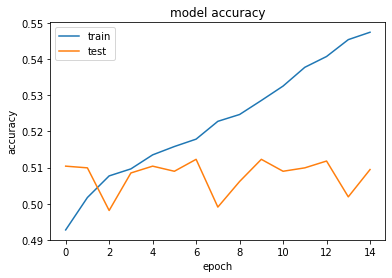

In [64]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
len(xethru_recordings[7])

In [ ]:
len(sleep_profiles[7]) * 30